In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using devie: %s" % device)

using devie: cuda


In [3]:
from segdataset import SegDataset

DS_ROOT = "E:\\datasets\\prepped"
train_ds = SegDataset(DS_ROOT, "train")
test_ds = SegDataset(DS_ROOT, "test")

print(f"train ds: {len(train_ds)}, test ds: {len(test_ds)}")

train ds: 367, test ds: 101


C:\Users\liang\AppData\Local\Temp\ipykernel_12620\1098849131.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


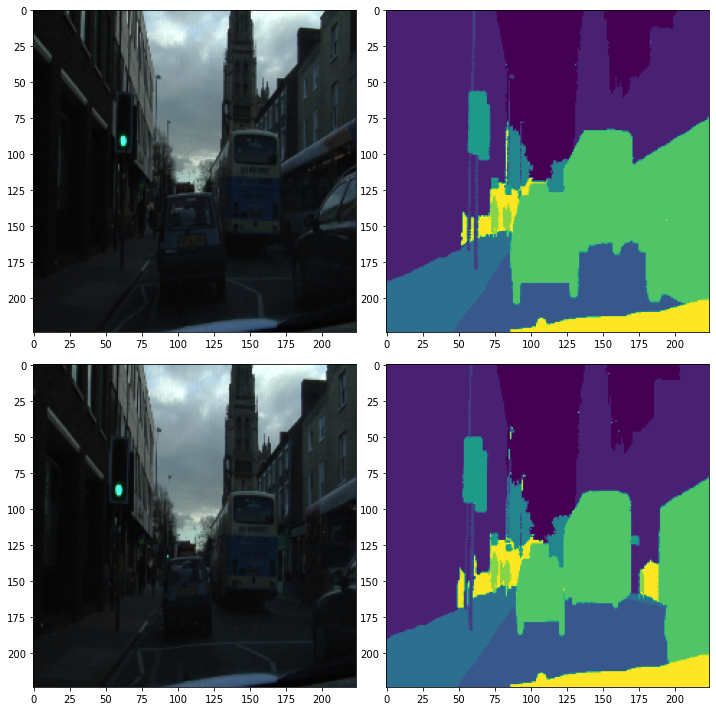

In [4]:
def imshow(ds, row, col, figsize=(6, 6)):
    fig, axes = plt.subplots(row, col*2, figsize=figsize)
    axes = list(axes.flat)
    for i in range(row * col):
        img, mask = ds[i]
        axes[i*2].imshow(img.permute(1,2,0))
        axes[i*2 + 1].imshow(mask)
    fig.tight_layout()
    fig.show()

imshow(train_ds, 2, 1, figsize=(10, 10))

In [5]:
# trainning preparation
from unet import Unet
from torchsummary import summary

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

model = Unet(pretrained=True)
#model = torch.load("unet_16.pt")
model = model.to(device)
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, dim=1)[1] == targets).float().mean()
    return ce_loss, acc

#summary(model, (3, 224, 224), device=device)

print(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
        
def train_batch(model, xs, ys, lossfn, optimizer):
    model.train()
    preds = model(xs)
    loss, acc = lossfn(preds, ys)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), acc.item()

@torch.no_grad()
def test_batch(model, xs, ys, lossfn):
    model.eval()
    preds = model(xs)
    loss, acc = lossfn(preds, ys)
    return loss.item(), acc.item()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\liang/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:26<00:00, 20.7MB/s]   


Unet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [6]:
# training
import time 
import numpy as np

for epoch in range(17, 100):
    start = time.time()

    losses = []
    acces = []
    for xs, ys in train_dl:
        xs = xs.to(device)
        ys = ys.to(device)
        loss, acc = train_batch(model, xs, ys, UnetLoss, optimizer)
        losses.append(loss)
        acces.append(acc)
    epoch_train_loss = np.mean(losses)
    epoch_train_acc = np.mean(acces)

    losses = []
    acces = []
    for xs, ys in test_dl:
        xs = xs.to(device)
        ys = ys.to(device)
        loss, acc = test_batch(model, xs, ys, UnetLoss)
        losses.append(loss)
        acces.append(acc)
    epoch_test_loss = np.mean(losses)
    epoch_test_acc = np.mean(acces)
    lr_scheduler.step(epoch_test_loss)

    consume = time.time() - start
    print(f"epoch {epoch}, consume {consume:.0f}s: \
        train loss={epoch_train_loss:.2f}, test loss = {epoch_test_loss:.2f}, \
        train acc = {epoch_train_acc:.2f}, test acc = {epoch_test_acc:.2f}")
    torch.save(model, f"unet_{epoch}.pt")

epoch 17, consume 17s:         train loss=1.16, test loss = 0.83,         train acc = 0.75, test acc = 0.82
epoch 18, consume 7s:         train loss=0.70, test loss = 0.74,         train acc = 0.82, test acc = 0.82
epoch 19, consume 7s:         train loss=0.60, test loss = 0.58,         train acc = 0.84, test acc = 0.86
epoch 20, consume 7s:         train loss=0.51, test loss = 0.53,         train acc = 0.86, test acc = 0.86
epoch 21, consume 7s:         train loss=0.49, test loss = 0.58,         train acc = 0.87, test acc = 0.84
epoch 22, consume 7s:         train loss=0.46, test loss = 0.65,         train acc = 0.87, test acc = 0.82
epoch 23, consume 7s:         train loss=0.42, test loss = 0.49,         train acc = 0.88, test acc = 0.87
epoch 24, consume 7s:         train loss=0.40, test loss = 0.48,         train acc = 0.89, test acc = 0.85
epoch 25, consume 7s:         train loss=0.37, test loss = 0.43,         train acc = 0.89, test acc = 0.87
epoch 26, consume 7s:         train 

torch.Size([224, 224])
torch.Size([224, 224])


C:\Users\liang\AppData\Local\Temp\ipykernel_12620\442989449.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


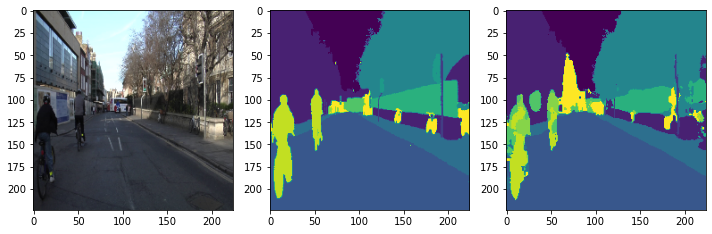

In [8]:
model = torch.load('unet_99.pt')
model.eval()

img, mask = test_ds.choose()
preds = model(img[None].to(device))
preds_mask = torch.max(preds, dim=1)[1][0].cpu()

print(mask.shape)
print(preds_mask.shape)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(img.permute(1,2,0))
axes[1].imshow(mask)
axes[2].imshow(preds_mask)
fig.tight_layout()
fig.show()